# Laboratorio 4 - Inteligencia Artificial

## Autores:

- Nelson García
- Andy Fuentes
- Davis Roldan
- Ricardo Chuy
- Diederich Solís

## Task 1 - Preguntas teóricas

## Task 2 - Ejercicios Prácticos

### Task 2.1 - K-Means y Segmentación de Clientes de Banco

### Ejercicio realizado con librerias

Ahora se realizará el mismo ejercicio de segmentacion de clientes pero utilizando las librerias apropiadas para usar el algoritmo de K-Medias. Con esto se busca realizar grupos con el set de datos de clientes de banco. Se hará selección principalmente de variables numéricas y de ser necesario se transformará alguna variable categórica a numérica si es que se considera relevante para la creación de clusters. 

Además de esto es importante mencionar que el set de datos no se encuentra balanceado, pero esto no representa un problema realmente. Ya que el clustering es un algoritmo de clasificación y aprendizaje no supervisado, no se tiene una columna objetivo. Por lo que no es neceario el balanceo de datos en este caso.

Para determinar el éxito del agrupamiento se usará el método de la silueta. Un recurso particularmente útil para evaluar el desepeño de modelos de agrupamiento como K-means, cluster jerárquico, entre otros.


In [198]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

In [199]:
df = pd.read_csv("banK_transactions.csv")

# TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
# T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25

numeric_variables = df[["CustAccountBalance","TransactionAmount (INR)"]]

print(numeric_variables.head())

# Nan
print(numeric_variables.isnull().sum())

imputer = SimpleImputer(strategy='mean')
scaled_df_imputed = pd.DataFrame(imputer.fit_transform(numeric_variables), columns=numeric_variables.columns)

scaled_df_imputed

# Check if NaN values are imputed
print(scaled_df_imputed.isnull().sum())


   CustAccountBalance  TransactionAmount (INR)
0            17819.05                     25.0
1             2270.69                  27999.0
2            17874.44                    459.0
3           866503.21                   2060.0
4             6714.43                   1762.5
CustAccountBalance         2369
TransactionAmount (INR)       0
dtype: int64
CustAccountBalance         0
TransactionAmount (INR)    0
dtype: int64


In [200]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(scaled_df_imputed)

#robust_scaler = RobustScaler()
#robust_scaled_df = robust_scaler.fit_transform(scaled_df_imputed[['CustAccountBalance', 'TransactionAmount (INR)']])

scaled_df = pd.DataFrame(scaled_features, columns=["CustAccountBalance","TransactionAmount (INR)"])
print(scaled_df.head())

   CustAccountBalance  TransactionAmount (INR)
0           -0.115412                -0.235650
1           -0.133801                 4.019119
2           -0.115347                -0.169639
3            0.888320                 0.073868
4           -0.128546                 0.028619


Para verificar la cantidad de clusteres ideal es necesario hacer un gráfico de codo.

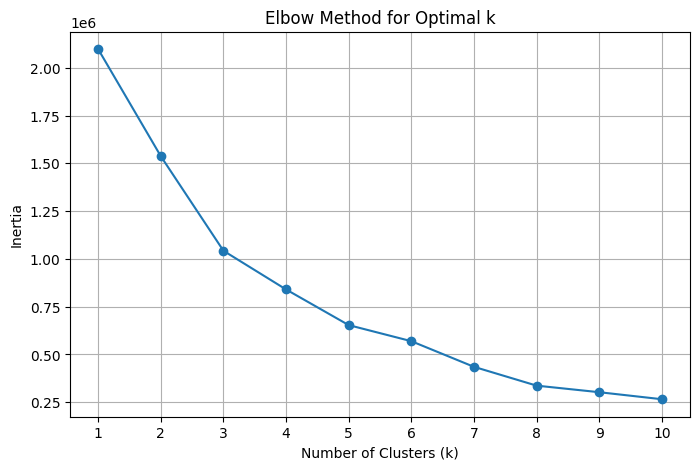

In [201]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.grid()
plt.show()

Con este gráfico se puede ver que el número óptimo de clusters probablemente sea 3 o 4.

In [202]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(scaled_df)

# Adding cluster column to original df
# df['Cluster'] = kmeans.labels_

#print(df[['CustAccountBalance', 'TransactionAmount (INR)', 'Cluster']].head())

KMeans(n_clusters=3, random_state=42)

Ademas de agregar la columnha cluster al df original, realizamos la evaluacion con la puntuación de la silueta. Nota: debido a la enorme cantidad de datos (más de 1 millón), se tomará una muestra para realizar la evaluación del clustering hecho por el algoritmo de K-Means.

In [207]:
sample_fraction = 0.10  
sampled_df = scaled_df.sample(frac=sample_fraction, random_state=42)

print(f"Muestra: {sampled_df.shape}")

silhouette_avg = silhouette_score(sampled_df, kmeans.labels_[sampled_df.index])
print(f"Silhouette Score: {silhouette_avg:.3f}")

# More metrics to see results using the complete data
db_index = davies_bouldin_score(scaled_df, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index:.3f}")

ch_index = calinski_harabasz_score(scaled_df, kmeans.labels_)
print(f"Calinski-Harabasz Index: {ch_index:.3f}")

Muestra: (104857, 2)
Silhouette Score: 0.955
Davies-Bouldin Index: 0.472
Calinski-Harabasz Index: 530469.816


Como se puede ver el valor de la métrica de silueta dió un valor de 0.956. Con esta métrica de desempeño, mientras más se acerca el valor a 1, quiere decir que el clustering fue más exitoso. Con ela métrica Davies-Bouldin Index, se obtuve un valor bastante bueno (mientras más cerca de 0 es mejor), lo cuál indica que los clusters se separan bastante bien y son compactos (no se superponen mucho). Ahora la última métrica mientras más alto sea el valor mejor (no tiene un máximo), ya que le valor es grande podemos decir que los clusters están bien diferenciados. Usamos más métricas para corroborar los resultados de la silueta, ya que usar el set de datos completo tomaría demasiado tiempo y recursos.-

#### Resultados del clustering
Los centroides se marcan con una X

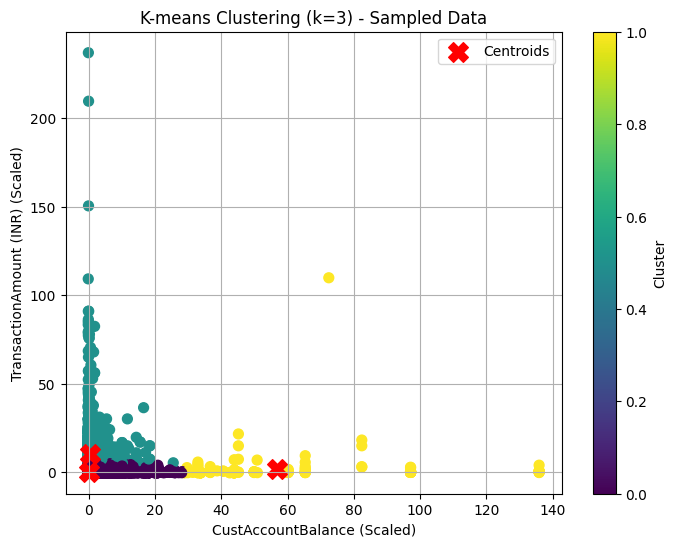

In [204]:
sssample = 1  # Adjust this as needed
sampled_df = scaled_df.sample(frac=sssample, random_state=42)

plt.figure(figsize=(8, 6))
plt.scatter(sampled_df.iloc[:, 0], sampled_df.iloc[:, 1], c=kmeans.labels_[sampled_df.index], cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('CustAccountBalance (Scaled)')
plt.ylabel('TransactionAmount (INR) (Scaled)')
plt.title('K-means Clustering (k=3) - Sampled Data')
plt.colorbar(label='Cluster')
plt.legend()
plt.grid()
plt.show()

#### Alternativa para visualizar

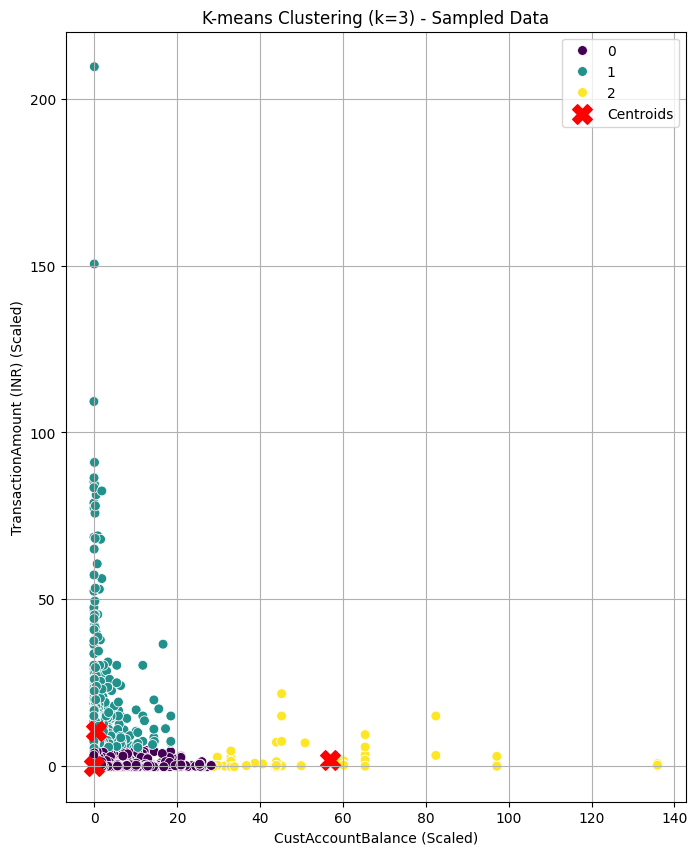

In [205]:
# Sample
sssample = 0.70  # Adjust this as needed
sampled_df = scaled_df.sample(frac=sssample, random_state=42)

sampled_df['Cluster'] = kmeans.labels_[sampled_df.index]

# Plot using Seaborn
plt.figure(figsize=(8, 10))
sns.scatterplot(data=sampled_df, x='CustAccountBalance', y='TransactionAmount (INR)', hue='Cluster', palette='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('CustAccountBalance (Scaled)')
plt.ylabel('TransactionAmount (INR) (Scaled)')
plt.title('K-means Clustering (k=3) - Sampled Data')
plt.legend()
plt.grid()
plt.show()

Al final podemos considerar el modelo exitoso debido a la métrica de evaluación de silueta. Lastimosamente no se puede usar el set completo para la evaluación, ya que tomá demasiad tiempo y recursos por la cantidad de datos (el csv tiene más de 1 millón). Es por eso que al final se incluyeron 2 metricas más para corroborar que el uso de una muestra es significativa y correcta. Además, aunque la información en la gráfica se mira abstante pegada a los ejes, esto no quiere decir que los grupos sean incorrectos, el hecho de que entre ellos los datos estén juntos da entender que los grupos son correctos, recordemos que la métrica de silueta evalua la distancia de los puntos al centroide.

### Task 2.2 - Mixture Modelos y Segmentación de Clientes de Banco